In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from datetime import datetime
import re
import os
import pandas as pd
from scipy.interpolate import *
from scipy.optimize import minimize, newton, NonlinearConstraint

from qfin.volsurf import VolatilitySurface, filter_delta, filter_volume
from qfin.utils import bs_explicit_call, bs_iv
from qfin.volsurf.filters import *

# Load volatility surface and plot SVI fits

In [3]:
date = datetime(2019, 4, 1)
datetime.strftime(date, '%Y%m%d')

'20190401'

/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/zeros.py:459: RuntimeWarning: some failed to converge after 50 iterations
  warnings.warn(msg, RuntimeWarning)
/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/zeros.py:459: RuntimeWarning: some failed to converge after 50 iterations
  warnings.warn(msg, RuntimeWarning)
/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during 

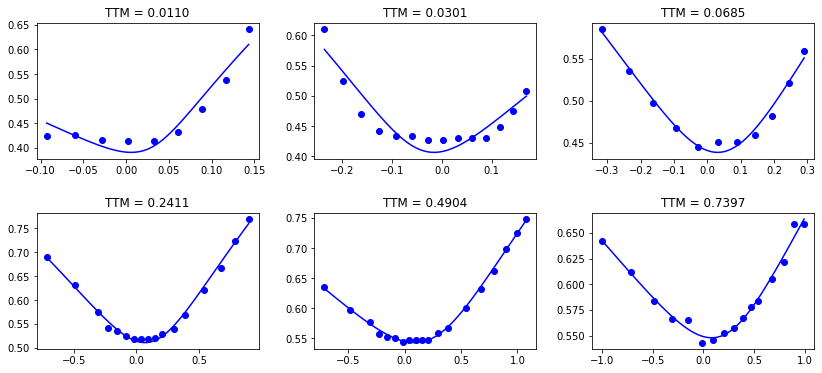

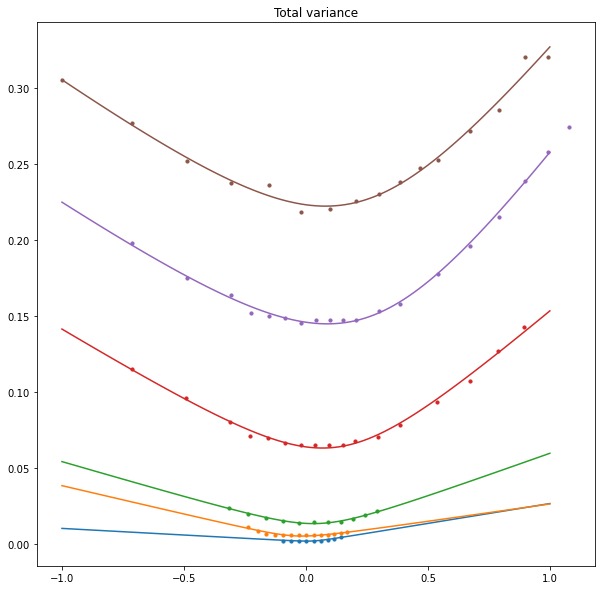

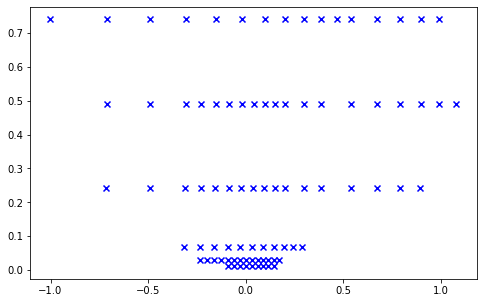

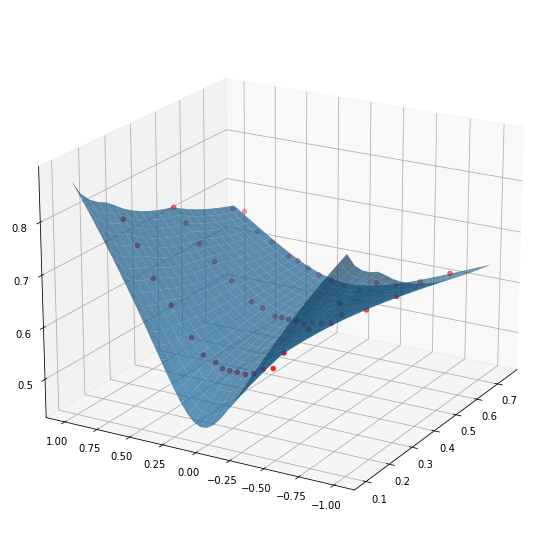

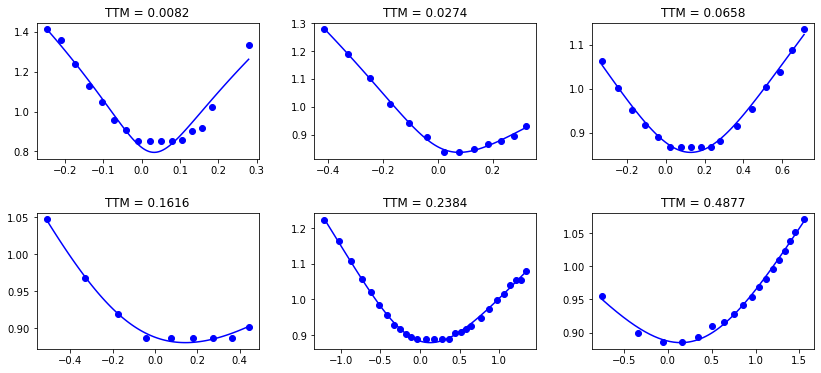

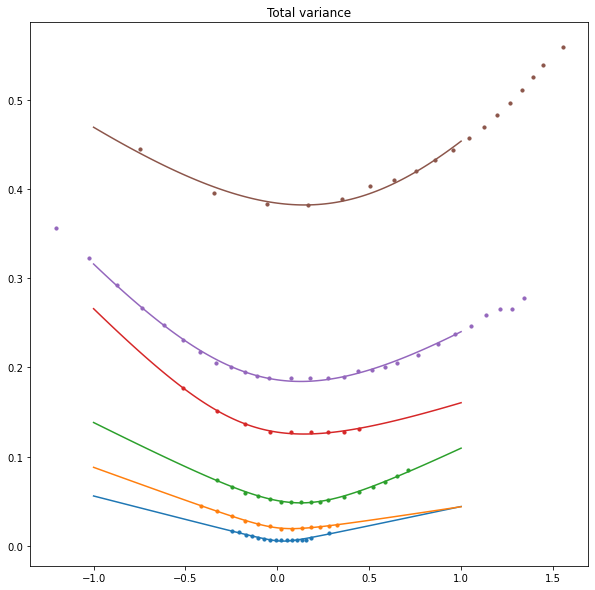

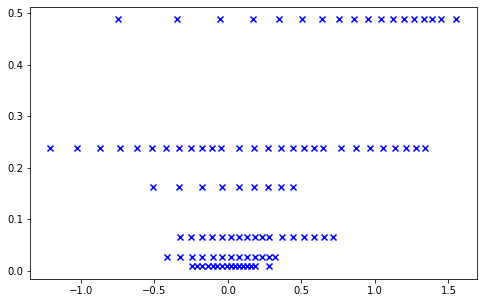

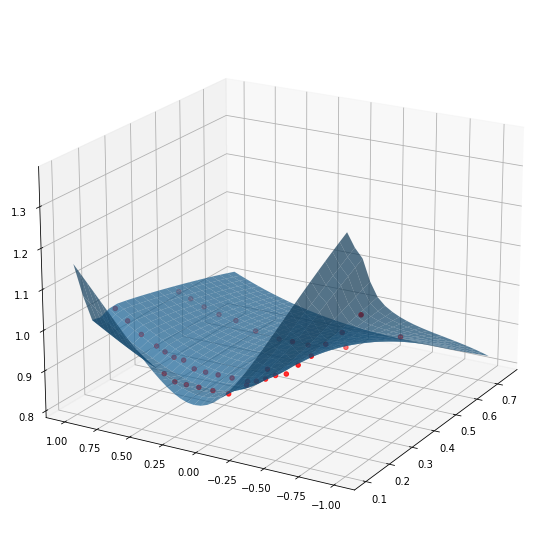

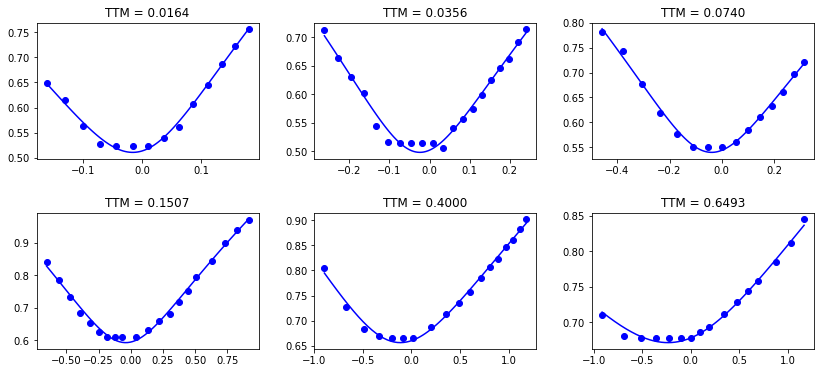

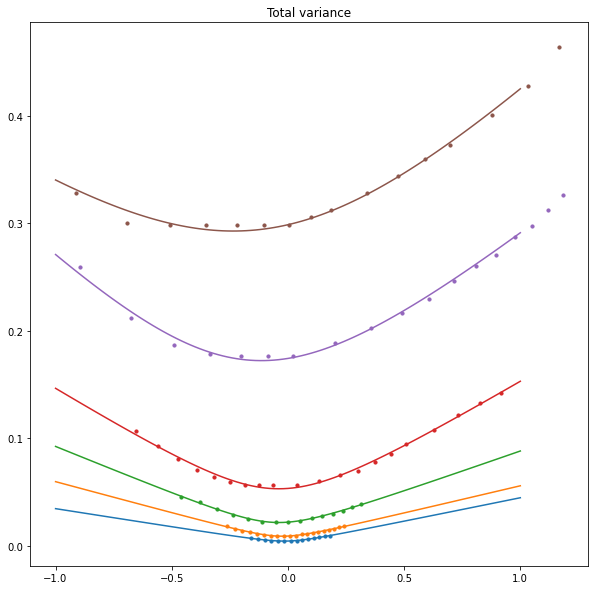

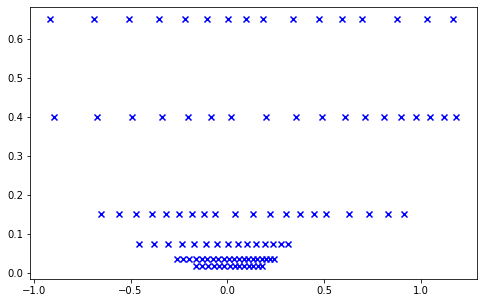

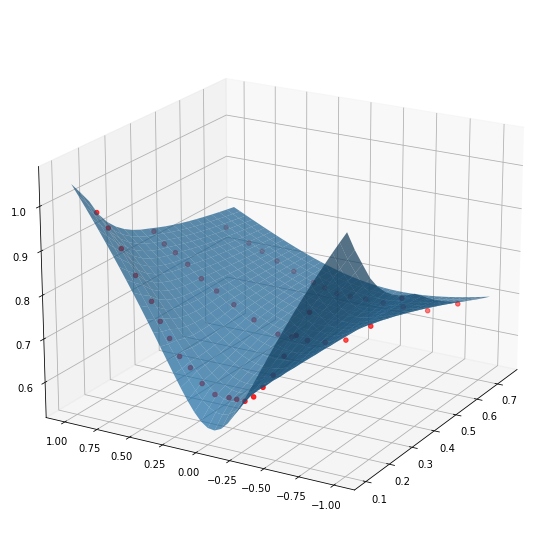

In [4]:
entries = [
    [datetime(2019, 4, 1), "BULLISH"],
    [datetime(2019, 10, 1), "CALM"],
    [datetime(2020, 2, 1), "COVID"],
]

for date, period_name in entries:

    filters = [filter_delta(0.01)]

    vs = VolatilitySurface.from_date(date, filters=filters)
    vs.calibrate()

    _ = vs.plot()
    _ = vs.plot_total_variance()
    _ = vs.plot_points()

    # plot 3d
    
    date_str = datetime.strftime(date, '%Y%m%d')

    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')

    BOUND = 1.
    
    # cutoff volsurf at the bottom at this ttm
    bd = 0.1

    x, y = np.meshgrid(np.linspace(bd, 0.75, 21), np.exp(np.linspace(-BOUND, BOUND, 41)))
    z = vs.iv(x, y)

    # ax.set_title(f"DATE = {date_str}, PERIOD = {period_name}")
    
    ax.view_init(azim=210, elev=20)
    ax.plot_surface(x, np.log(y), z, linewidth=0.2, antialiased=True, alpha=0.7)

    df = vs.data[np.abs(np.log(vs.data['moneyness'])) <= BOUND]
    ax.scatter(df.loc[df['ttm'] > bd, 'ttm'], np.log(df.loc[df['ttm'] > bd, 'moneyness']), df.loc[df['ttm'] > bd, 'iv'], c='r')

    fig.savefig(f'_output/volsurf/figures/{date_str}.pdf', bbox_inches='tight')

# Calculate IV for all paths

In [ ]:
dt = 1/365
sigma = 1.
s0 = 1.
rate = 0.

paths = s0 * np.exp(np.cumsum(np.pad(sigma**2/2 * dt + sigma * np.sqrt(dt) * np.random.standard_normal((10000, 179)), ((0, 0), (1, 0))), axis=1))
ttm = np.linspace(180 * dt, dt, 180)
strike = 1.

iv = vs.iv(ttm, strike / paths)
calls = bs_explicit_call(ttm, strike, paths, rate, vs.iv(ttm, strike / paths))

fig, ax = plt.subplots()

idx = 0
ax.plot(paths[idx, :], c='b')
ax.twinx().plot(calls[idx, :], c='r')

# Examine SVI fits

In [ ]:
fnames = [fname for fname in os.listdir("_output/volsurf/svi") if fname.endswith("csv")]
rows = []

for fname in fnames:
    df = pd.read_csv("_output/volsurf/svi/" + fname)
    items = df[['ttm', 'a', 'b', 'rho', 'm', 'sigma', 'penalty']].to_numpy()
    date = fname[:8]
    rows += [[date, *item] for item in items]
    
df = pd.DataFrame(rows, columns=['date', 'ttm', 'a', 'b', 'rho', 'm', 'sigma', 'penalty'])

In [ ]:
df.sort_values('penalty', ascending=False)[:20]

In [ ]:
date = datetime.strptime("20200326", "%Y%m%d")
vs = VolatilitySurface(date)
_ = vs.plot()
_ = vs.plot_total_variance()